### Описание проекта
Помочь маркетологам оптимизировать маркетинговые затраты.
У вас в распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

### Шаг 1. Загрузите данные и подготовьте их к анализу
Загрузите данные о визитах, заказах и расходах в переменные. Оптимизируйте данные для анализа. Убедитесь, что тип данных в каждой колонке — правильный.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [3]:
visits.head(2)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740


In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [6]:
orders.head(2)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447


In [7]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [8]:
visits.rename(columns={'Device':'device', 'End Ts':'end_ts', 
                       'Source Id':'source_id', 'Start Ts':'start_ts', 
                       'Uid':'uid'}, inplace=True)
orders.rename(columns={'Buy Ts':'buy_ts', 'Revenue':'revenue', 'Uid':'uid'}, inplace=True)

visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

In [9]:
orders.head(2)

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447


In [10]:
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')
visits['session_week'] = visits['start_ts'].astype('datetime64[W]')
visits['session_date'] = visits['start_ts'].dt.date

In [11]:
visits.duplicated().sum()

0

In [12]:
orders.duplicated().sum()

0

In [13]:
costs.duplicated().sum()

0

Названия столбцов привел к нижнему регистру, пробелы заменил на нажнее подчеркивание. Все даты перевел в тип datetime. Дубликатов в данных не нашел.
В данных visits доабвил столбцы с месяцем и неделей визита.

### Шаг 2. Постройте отчёты и посчитайте метрики

### Продукт

#### Сколько людей пользуются в день, неделю, месяц?

In [14]:
visits['session_date'] = pd.to_datetime(visits['session_date'])

In [15]:
visits.head()

,device,end_ts,source_id,start_ts,uid,session_month,session_week,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,2017-12-14,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2018-02-15,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,2018-05-17,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-01,2017-12-21,2017-12-27


In [16]:
dau_total = visits.groupby('session_date').agg({'uid':'nunique'}).mean()
wau_total = visits.groupby('session_week').agg({'uid':'nunique'}).mean()
mau_total = visits.groupby('session_month').agg({'uid':'nunique'}).mean()

In [17]:
print('Каждый день в среднем заходят', int(dau_total), 'пользователей')
print('Каждую неделю в среднем заходят', int(wau_total), 'пользователей')
print('Каждый месяц в среднем заходят', int(mau_total), 'пользователей')

Каждый день в среднем заходят 907 пользователей
Каждую неделю в среднем заходят 5724 пользователей
Каждый месяц в среднем заходят 23228 пользователей


In [18]:
for_dau = visits.groupby(['device', 'source_id','session_date']).agg({'uid':'nunique'}).reset_index()
for_wau = visits.groupby(['device', 'source_id','session_week',]).agg({'uid':'nunique'}).reset_index()
for_mau = visits.groupby(['device', 'source_id','session_month',]).agg({'uid':'nunique'}).reset_index()

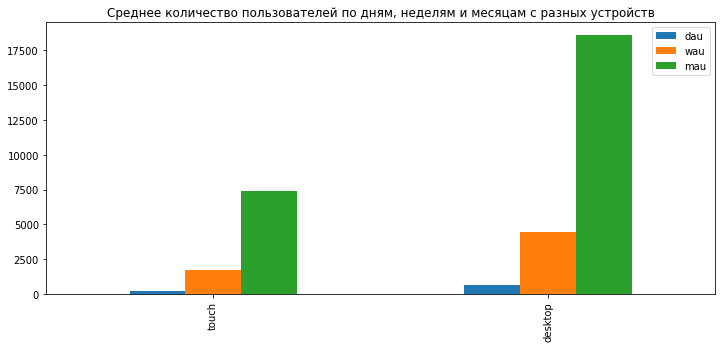

In [19]:
# DAU, WAU, MAU по утстройствам
dau_devices = []
wau_devices = []
mau_devices = []
for device_name in visits['device'].unique():
    mean_value_dau = for_dau.pivot_table(index='device', columns='session_date', 
                                         values='uid', aggfunc='sum').loc[device_name].mean().astype('int') 
    mean_value_wau = for_wau.pivot_table(index='device', columns='session_week', 
                                         values='uid', aggfunc='sum').loc[device_name].mean().astype('int')
    mean_value_mau = for_mau.pivot_table(index='device', columns='session_month', 
                                         values='uid', aggfunc='sum').loc[device_name].mean().astype('int')
    dau_devices.append(mean_value_dau)
    wau_devices.append(mean_value_wau)
    mau_devices.append(mean_value_mau)

dau_wau_mau_devices_dict= {'dau':dau_devices, 'wau':wau_devices, 'mau':mau_devices}
dau_wau_mau_devices = pd.DataFrame(data=dau_wau_mau_devices_dict, index=visits['device'].unique())

dau_wau_mau_devices.plot(kind='bar', figsize=(12,5),
                         title='Среднее количество пользователей по дням, неделям и месяцам с разных устройств');

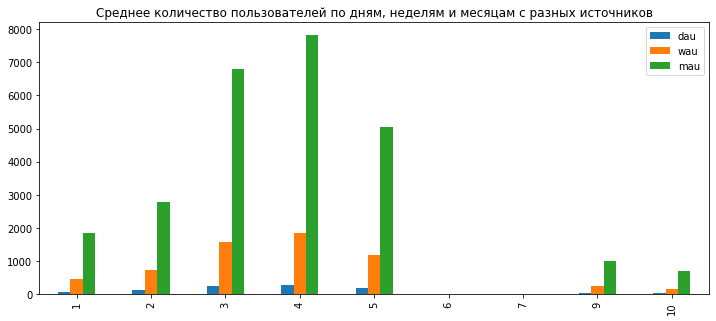

In [20]:
# DAU, WAU, MAU по ресурсам привлечения клиента
dau_source = []
wau_source = []
mau_source = []
for source_id in visits['source_id'].sort_values().unique():
    mean_value_dau = for_dau.pivot_table(index='source_id', columns='session_date', 
                                         values='uid', aggfunc='sum').loc[source_id].mean().astype('int') 
    mean_value_wau = for_wau.pivot_table(index='source_id', columns='session_week', 
                                         values='uid', aggfunc='sum').loc[source_id].mean().astype('int')
    mean_value_mau = for_mau.pivot_table(index='source_id', columns='session_month', 
                                         values='uid', aggfunc='sum').loc[source_id].mean().astype('int')
    dau_source.append(mean_value_dau)
    wau_source.append(mean_value_wau)
    mau_source.append(mean_value_mau)

dau_wau_mau_source_dict = {'dau':dau_source, 'wau':wau_source, 'mau':mau_source}
dau_wau_mau_source = pd.DataFrame(data=dau_wau_mau_source_dict, index=visits['source_id'].sort_values().unique())

dau_wau_mau_source.plot(kind='bar', figsize=(12,5),
                         title='Среднее количество пользователей по дням, неделям и месяцам с разных источников');

In [21]:
dau_wau_mau_source

,dau,wau,mau
1,80,467,1832
2,121,721,2786
3,233,1571,6797
4,275,1837,7813
5,175,1169,5031
6,1,1,1
7,1,1,2
9,36,239,994
10,26,167,710


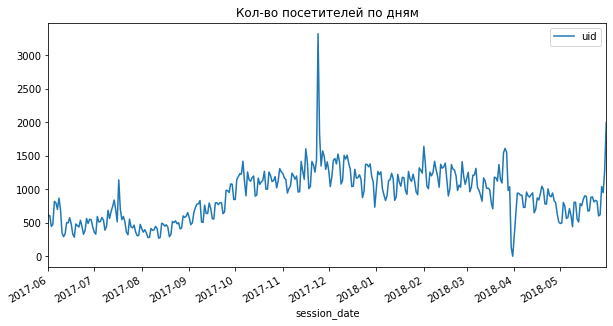

In [22]:
visits.groupby('session_date').agg({'uid':'nunique'}).plot(title='Кол-во посетителей по дням', figsize=(10,5));

In [23]:
visits.groupby('session_date').agg({'uid':'nunique'}).query('uid > 3000')

,uid
session_date,
2017-11-24,3319


In [24]:
visits.groupby('session_date').agg({'uid':'nunique'}).query('uid < 10')

,uid
session_date,
2018-03-31,1


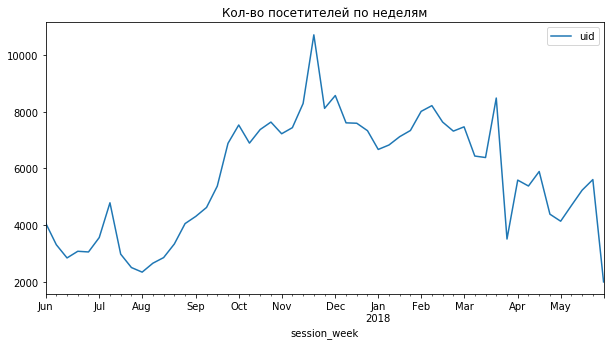

In [25]:
visits.groupby('session_week').agg({'uid':'nunique'}).plot(title='Кол-во посетителей по неделям', figsize=(10,5));

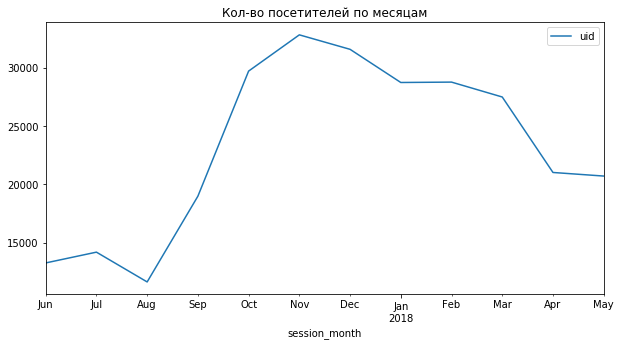

In [26]:
visits.groupby('session_month').agg({'uid':'nunique'}).plot(title='Кол-во посетителей по месяцам', figsize=(10,5));

На дневных временных шкалах видно, что несколько дней в ноябре выбивается. 24 ноября 2017 года было 3319 уникальных посетителей, а 31 марта 2018 года пришел только один посетитель за целый день.
На недельных и месячных графиках кол-ва посетителей видно, что с сентября по апрель клиенты интересуются мероприятиями. Начиная с апреля активность начинает падать и до конца лета постепенно падает. 

#### Сколько сессий в день?

In [27]:
sessions_per_user = visits.groupby(['session_month', 'device']).agg({'uid':['count', 'nunique']})
sessions_per_user.columns = ['n_session', 'n_users']
sessions_per_user['sessions_per_user'] = sessions_per_user['n_session'] / sessions_per_user['n_users']
sessions_per_user

n_session  n_users  sessions_per_user
session_month device                                        
2017-06-01    desktop      12358     9761           1.266059
              touch         4147     3655           1.134610
2017-07-01    desktop      12950    10145           1.276491
              touch         4878     4223           1.155103
2017-08-01    desktop      10854     8611           1.260481
              touch         3501     3132           1.117816
2017-09-01    desktop      17356    13509           1.284773
              touch         6551     5679           1.153548
2017-10-01    desktop      27392    21286           1.286855
              touch        10511     8856           1.186879
2017-11-01    desktop      32917    24439           1.346905
              touch        11052     8913           1.239987
2017-12-01    desktop      31112    23294           1.335623
              touch        10871     8785           1.237450
2018-01-01    desktop      26577    20350           1.305995
              touch        10362     8741           1.185448
2018-02-01    desktop      27077    20574           1.316079
              touch        10105     8590           1.176368
2018-03-01    desktop      25861    19574           1.321191
              touch         9818     8303           1.182464
2018-04-01    desktop      19231    14844           1.295540
              touch         7284     6387           1.140442
2018-05-01    desktop      18882    14312           1.319312
              touch         7753     6647           1.166391

Одна сессия в день

#### Сколько длится одна сессия?

In [28]:
visits['session_duration_sec'] = (visits['end_ts']-visits['start_ts']).dt.seconds
visits['session_duration_sec'].mean()

643.506488592098

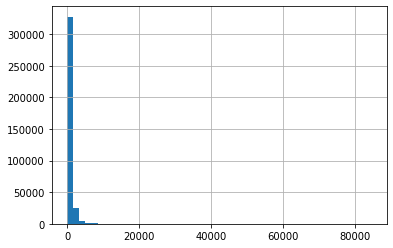

In [29]:
visits['session_duration_sec'].hist(bins=50)

In [30]:
visits['session_duration_sec'].mode()

0    60
dtype: int64

Распределение совсем не близко к нормальному, поэтому смотрел моду длительности сессии и она состваляет 60 секунд.

#### Как часто люди возвращаются?

In [31]:
visits.head()

,device,end_ts,source_id,start_ts,uid,session_month,session_week,session_date,session_duration_sec
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,2017-12-14,2017-12-20,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,2018-02-15,2018-02-19,1680
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-01,2018-05-17,2018-05-20,1440
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-01,2017-12-21,2017-12-27,0


In [32]:
first_activity_day = visits.groupby('uid')['start_ts'].min()
first_activity_day.name = 'first_session_date'
visits = visits.join(first_activity_day, on='uid')

In [33]:
visits['first_session_date'] = visits['first_session_date'].astype('datetime64[M]')
visits['session_date'] = visits['start_ts'].astype('datetime64[M]')

In [34]:
visits['cohort_lifetime']= ((visits['session_date']-visits['first_session_date']) / np.timedelta64(1,'M')).round().astype('int')

#### Анализ удержания клиентов, которые пришли первый раз в разные месяцы

In [35]:
cohorts_month = visits.groupby(['first_session_date', 'cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

In [36]:
initial_users_count  = cohorts_month[cohorts_month['cohort_lifetime'] == 0][['first_session_date','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
cohorts_month = cohorts_month.merge(initial_users_count,on='first_session_date')
cohorts_month['retention'] = cohorts_month['uid']/cohorts_month['cohort_users']
retention_pivot_month = cohorts_month.pivot_table(index='first_session_date',columns='cohort_lifetime',values='retention',aggfunc='sum')

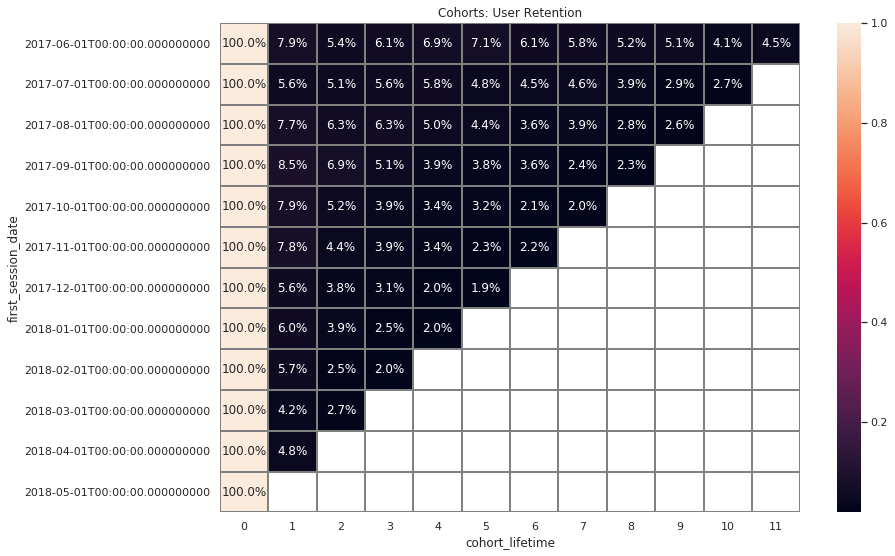

In [37]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot_month, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

Только от 4 до 8 % клиентов возвращаются на сайт во второй месяц жизни когорты. Большинство когорт продолжает терять клинетов, и только когортам июня и июля 2017 когда удается поднять коэффициент удержания на несколько месяцев, но последующим снижением. 
У июньской когорты 2017 года на последний месяц лучший процент удержания клентов. В данном анализе проводилась активность клиентов на сайте без учета совершения покупки. 

#### Анализ удержания клиентов, которые пришли первый раз с разных устройств

In [38]:
cohorts_device = visits.groupby(['device', 'cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

In [39]:
initial_users_count_device  = cohorts_device[cohorts_device['cohort_lifetime'] == 0][['device', 'uid']]
initial_users_count_device = initial_users_count_device.rename(columns={'uid':'cohort_users'})

In [40]:
cohorts_device = cohorts_device.merge(initial_users_count_device,on=['device'])
cohorts_device['retention'] = cohorts_device['uid']/cohorts_device['cohort_users']

In [41]:
retention_pivot_device = cohorts_device.pivot_table(index='device', columns='cohort_lifetime',values='retention',aggfunc='sum')

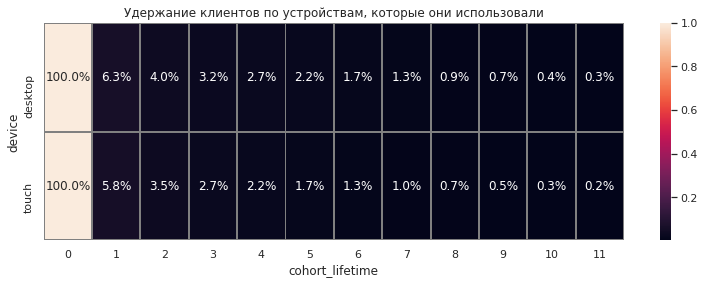

In [42]:
sns.set(style='white')
plt.figure(figsize=(13, 4))
plt.title('Удержание клиентов по устройствам, которые они использовали')
sns.heatmap(retention_pivot_device, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

In [43]:
cohorts_device_month = visits.groupby(['device', 'first_session_date','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

In [44]:
initial_users_count_device_month = cohorts_device_month[cohorts_device_month['cohort_lifetime'] == 0][['device', 
                                                                                                       'first_session_date', 
                                                                                                       'uid']]
initial_users_count_device_month = initial_users_count_device_month.rename(columns={'uid':'cohort_users'})

In [45]:
cohorts_device_month = cohorts_device_month.merge(initial_users_count_device_month,on=['device', 'first_session_date'])
cohorts_device_month['retention'] = cohorts_device_month['uid']/cohorts_device_month['cohort_users']

In [46]:
retention_pivot_device_month = cohorts_device_month.pivot_table(index=['device','first_session_date'], 
                                                                columns='cohort_lifetime',
                                                                values='retention',aggfunc='sum')

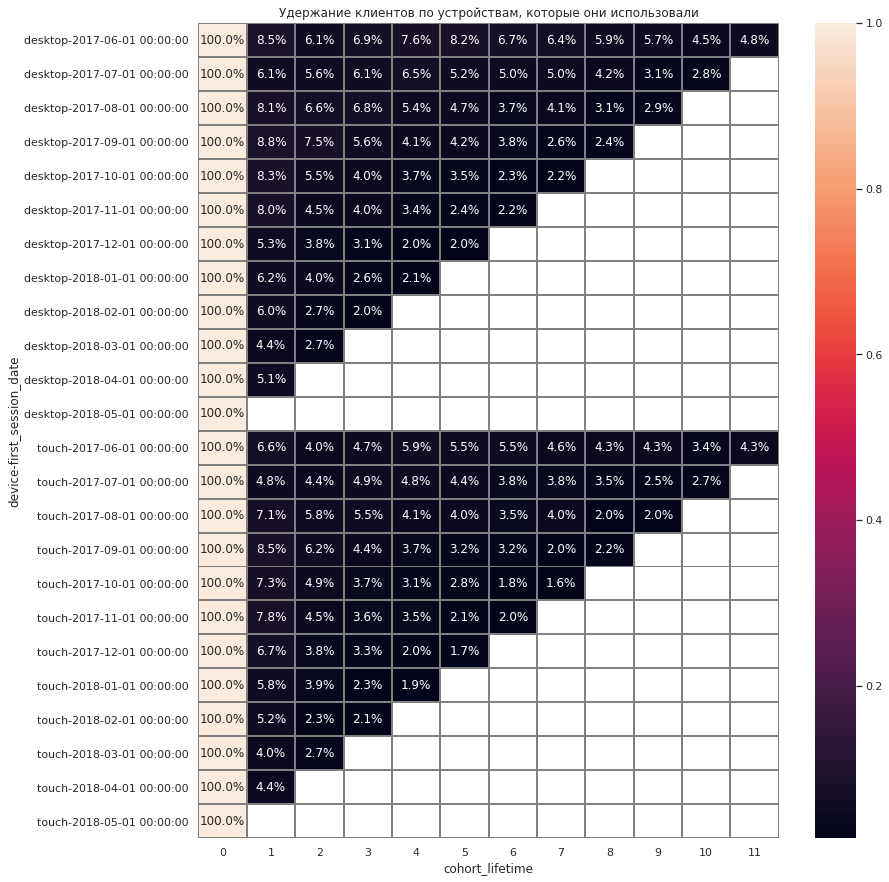

In [47]:
sns.set(style='white')
plt.figure(figsize=(13, 15))
plt.title('Удержание клиентов по устройствам, которые они использовали')
sns.heatmap(retention_pivot_device_month, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

* Когорты по устройствам примерно одинаковы в потере клиентов. На второй месяц возвращалость примерно 6% клиентов, заходившие в первый раз и с компьютера и с мобильного утсройства. Через 12 месцев осталось только 0.3 % посетителей с десктопных устройств и 0.2 % посетителей с мобильных устройств.
* Если рассмотреть использованние устройств по когортам, то когорта июня лучше всего сохраняет клиентов вне зависимости от устройства, с которого первый раз пришли посетители. 

#### Анализ удержания клиентов, которые пришли первый раз с разных ресурсов

In [48]:
cohorts_source = visits.groupby(['source_id', 'cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

In [49]:
initial_users_count_source = cohorts_source[cohorts_source['cohort_lifetime'] == 0][['source_id', 'uid']]
initial_users_count_source = initial_users_count_source.rename(columns={'uid':'cohort_users'})

In [50]:
cohorts_source = cohorts_source.merge(initial_users_count_source,on='source_id')
cohorts_source['retention'] = cohorts_source['uid'] / cohorts_source['cohort_users']

In [51]:
retention_pivot_source = cohorts_source.pivot_table(index='source_id', columns='cohort_lifetime', values='retention',aggfunc='sum')

In [52]:
retention_pivot_source

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,1.0,0.130952,0.067118,0.053523,0.046168,0.038025,0.028765,0.024102,0.015105,0.013069,0.009260,0.007224
2,1.0,0.152467,0.088803,0.070546,0.058562,0.047748,0.039837,0.029211,0.021955,0.016337,0.012078,0.008426
3,1.0,0.043568,0.029833,0.026552,0.021507,0.017716,0.013692,0.010673,0.007626,0.005205,0.003835,0.002406
4,1.0,0.062130,0.039738,0.030610,0.025039,0.021641,0.016003,0.011788,0.008548,0.005545,0.003859,0.002516
5,1.0,0.044032,0.026526,0.019928,0.015389,0.013025,0.009325,0.007285,0.005130,0.003471,0.002403,0.001773
6,1.0,0.250000,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1.0,0.031250,NaN,NaN,0.031250,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1.0,0.159949,0.130287,0.092109,0.084019,0.065995,0.046551,0.036333,0.028101,0.021005,0.010644,0.005961
10,1.0,0.048944,0.025912,0.021799,0.018783,0.011242,0.009460,0.009597,0.008089,0.004524,0.003153,0.001645


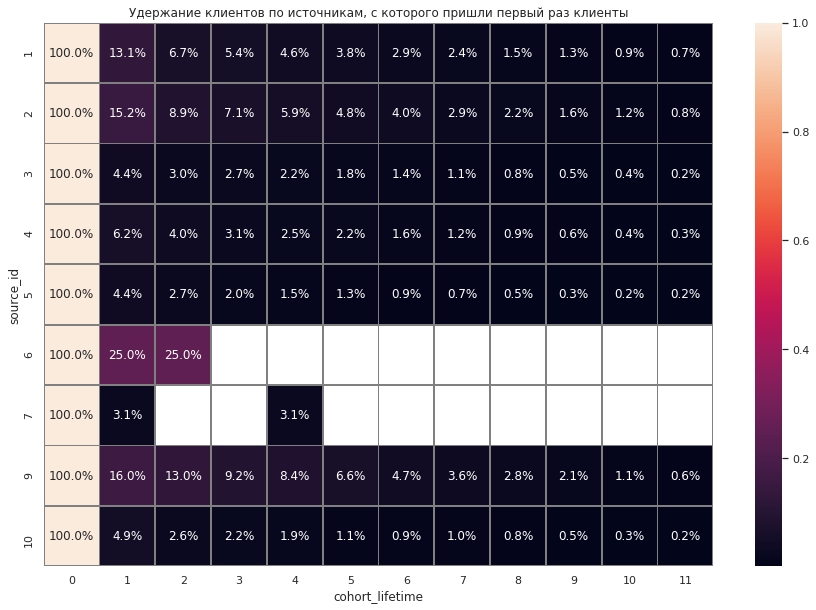

In [53]:
sns.set(style='white')
plt.figure(figsize=(15, 10))
plt.title('Удержание клиентов по источникам, с которого пришли первый раз клиенты')
sns.heatmap(retention_pivot_source, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

На второй месяц пришло 25% клиентов с ресурса № 6. На протяжении 2 месяцев они возвращались в колличестве 25%. Предположу, что с этого реcурса мало клиентов пришло, они сделалу покупку и потом заходили посмотреть дату и место проведения концерта или мероприятия, ряд или место, приобретенного билета. На четвертый месяц клиентов с жтого ресурса не возвращалось. 
Ресурс № 9 показал лучший коэффициент удержания на протяжении 9-10 месяцев.

### Продажи

#### Когда люди начинают покупать?

In [54]:
first_visit = (visits.sort_values(by=['uid', 'start_ts']).groupby('uid')
               .agg({'start_ts':'first', 'source_id':'first', 'device':'first'})
               .rename(columns={'start_ts':'first_start_ts'}))

In [55]:
first_order = orders.groupby('uid').agg({'buy_ts':'min'}).rename(columns={'buy_ts':'first_buy'})

In [56]:
first_visit_order = first_visit.merge(first_order, on='uid')

In [57]:
first_visit_order['first_start_date'] = first_visit_order['first_start_ts'].dt.date
first_visit_order['buy_date'] = first_visit_order['first_buy'].dt.date
first_visit_order['day_to_order'] = (first_visit_order['buy_date'] - first_visit_order['first_start_date'])
first_visit_order['day_to_order'] = (first_visit_order['day_to_order'] / np.timedelta64(1, 'D')).round().astype('int')

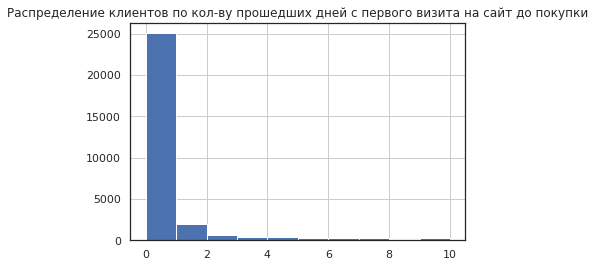

In [58]:
plt.title('Распределение клиентов по кол-ву прошедших дней с первого визита на сайт до покупки')
first_visit_order['day_to_order'].hist(bins=10, range=(0,10));

In [59]:
first_visit_order[first_visit_order['day_to_order'] == 0]['day_to_order'].count() / first_visit_order.shape[0]

0.6855679982476796

70% клиентов, которые сделали покупку, покупают в день визита сайта.

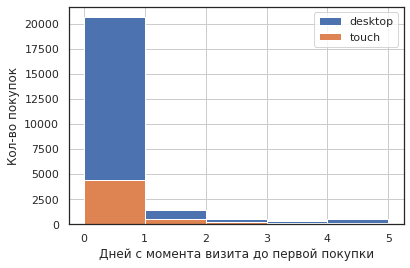

In [60]:
for device_name in first_visit_order['device'].unique():
    first_visit_order.query('device == @device_name')['day_to_order'].hist(range=(0,5), bins=5);   
    plt.legend(first_visit_order['device'].unique())
    plt.xlabel('Дней с момента визита до первой покупки')
    plt.ylabel('Кол-во покупок')

С десктопных устройств покупают чаще.

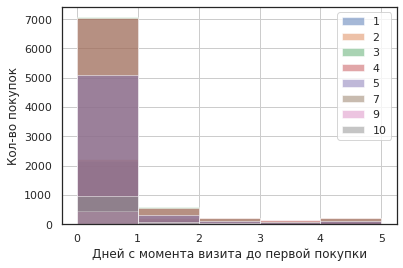

In [61]:
for source_index in first_visit_order['source_id'].sort_values().unique():
    #plt.subplot(figsize=(10,5))
    first_visit_order.query('source_id == @source_index')['day_to_order'].hist(range=(0,5), bins=5, alpha=0.5);   
    plt.legend(first_visit_order['source_id'].sort_values().unique())
    plt.xlabel('Дней с момента визита до первой покупки')
    plt.ylabel('Кол-во покупок')

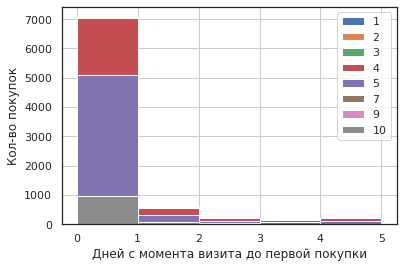

In [62]:
for source_index in first_visit_order['source_id'].sort_values().unique():
    #plt.subplot(figsize=(10,5))
    first_visit_order.query('source_id == @source_index')['day_to_order'].hist(range=(0,5), bins=5, alpha=1);   
    plt.legend(first_visit_order['source_id'].sort_values().unique())
    plt.xlabel('Дней с момента визита до первой покупки')
    plt.ylabel('Кол-во покупок')

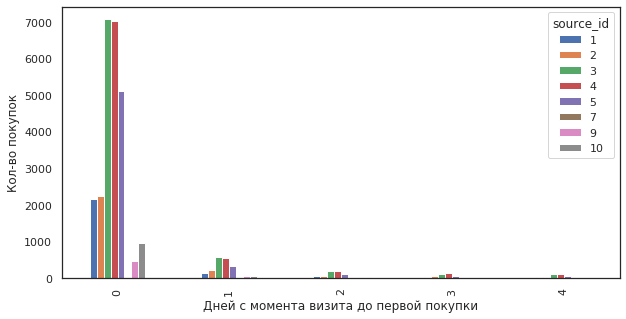

In [63]:
# Сгруппирую по дням прошедшим с первого дня визита до первой покупки и по ресурсам. 
# Буду смотреть на данные до 4 дней до покупки
first_4_day = (first_visit_order.reset_index().groupby(['day_to_order','source_id'])
                                        .agg({'uid':'nunique'}).reset_index()
                                        .query('day_to_order <= 4'))

#Сводная тадлица где в строках кол-во дней до покупки (от 0 до 4), а в столбцах источник привлечения
first_4_day_pt = first_4_day.pivot_table(index='day_to_order', columns='source_id', values='uid')
first_4_day_pt

first_4_day_pt.plot(kind='bar', figsize=(10,5))
plt.xlabel('Дней с момента визита до первой покупки')
plt.ylabel('Кол-во покупок');

Клиенты с ресурсов 4 и 3 покупают больше, чем с других ресурсов. У них около 7 тыс. покупателей в день первого визита клиента. С ресурса 5 таких клиентов около 5 тысяч. У ресурсов 1 и 2 около 2.5 тыс покупок в день первого захода на сайт. С ресурса 7 только 1 клиент сделал покупку.

#### Сколько раз покупают за период?

In [64]:
orders['purchase_date'] = orders['buy_ts'].astype('datetime64[D]')
orders['purchase_week'] = orders['buy_ts'].astype('datetime64[W]')
orders['purchase_month'] = orders['buy_ts'].astype('datetime64[M]')

In [65]:
dau_total = orders.groupby('purchase_date').agg({'uid':'count'})
wau_total = orders.groupby('purchase_week').agg({'uid':'count'})
mau_total = orders.groupby('purchase_month').agg({'uid':'count'})

In [66]:
print('DAU:', int(dau_total.mean()))
print('WAU:', int(wau_total.mean()))
print('MAU:', int(mau_total.mean()))

DAU: 138
WAU: 951
MAU: 3878


#### Какой средний чек?

In [67]:
orders = orders.join(orders.groupby('uid').agg({'buy_ts':'min'}).rename(columns = {'buy_ts':'first_order'}),
                     on='uid')

In [68]:
orders['first_order_month'] = orders['first_order'].astype('datetime64[M]')

In [69]:
# найду средний чек покупателя по месячным когортам

In [70]:
test_1 = orders.groupby(['first_order_month', 'purchase_month']).agg({'revenue':'sum', 'uid':'nunique'})
test_1['revenue_per_user'] = test_1['revenue'] / test_1['uid']

#test_1.pivot_table(index='first_order_month',columns='purchase_month',values='revenue_per_user',aggfunc='mean')

test_1 = test_1.reset_index()
test_1['cohort_lifetime'] = test_1['purchase_month'] - test_1['first_order_month']
#test_1['cohort_lifetime'].head()

test_1['cohort_lifetime'] = test_1['cohort_lifetime'] / np.timedelta64(1,'M')
test_1['cohort_lifetime'] = test_1['cohort_lifetime'].round().astype('int')
test_1

revenue_per_user_pivot_test = test_1.pivot_table(index='first_order_month',
                                                               columns='cohort_lifetime',
                                                               values='revenue_per_user',
                                                               aggfunc='mean')
revenue_per_user_pivot_test

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.724414,16.095410,17.706800,35.764815,23.506591,22.207761,31.011935,25.033191,19.295690,27.233556,25.681333,9.804151
2017-07-01,6.010218,12.396346,21.035965,10.786094,6.938163,7.896842,6.421111,6.992821,7.382143,12.861818,11.513846,NaN
2017-08-01,5.276518,11.148793,11.851321,12.182955,16.921250,12.139063,9.620333,12.610455,21.070000,8.307419,NaN,NaN
2017-09-01,5.644529,22.188385,13.445200,138.669189,19.881538,26.095000,27.437121,16.961351,11.044651,NaN,NaN,NaN
2017-10-01,5.003733,11.287427,6.753252,7.413152,7.072796,7.255139,6.573214,7.479701,NaN,NaN,NaN,NaN
2017-11-01,5.154683,7.339054,6.786583,12.510660,7.457284,4.580833,7.564839,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.738191,7.816575,39.366019,48.135052,27.431400,23.518413,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.135636,8.721228,12.365542,11.199767,4.699556,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.156987,8.610000,4.942414,6.941026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
test_1

,first_order_month,purchase_month,revenue,uid,revenue_per_user,cohort_lifetime
0,2017-06-01,2017-06-01,9557.49,2023,4.724414,0
1,2017-06-01,2017-07-01,981.82,61,16.095410,1
2,2017-06-01,2017-08-01,885.34,50,17.706800,2
3,2017-06-01,2017-09-01,1931.30,54,35.764815,3
4,2017-06-01,2017-10-01,2068.58,88,23.506591,4
...,...,...,...,...,...,...
74,2018-03-01,2018-05-01,1114.87,58,19.221897,2
75,2018-04-01,2018-04-01,10600.69,2276,4.657597,0
76,2018-04-01,2018-05-01,1209.92,69,17.535072,1
77,2018-05-01,2018-05-01,13925.76,2988,4.660562,0


In [72]:
order_grouped_by_cohorts = orders.groupby(['first_order_month', 'purchase_month']).agg({'revenue':'sum', 'uid':'nunique'})

order_grouped_by_cohorts['revenue_per_user'] = order_grouped_by_cohorts['revenue'] / order_grouped_by_cohorts['uid']

In [73]:
order_grouped_by_cohorts.pivot_table(index='first_order_month', columns='purchase_month',
                                     values='revenue_per_user', aggfunc='mean')

purchase_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,4.724414,16.095410,17.706800,35.764815,23.506591,22.207761,31.011935,25.033191,19.295690,27.233556,25.681333,9.804151,NaN
2017-07-01,NaN,6.010218,12.396346,21.035965,10.786094,6.938163,7.896842,6.421111,6.992821,7.382143,12.861818,11.513846,NaN
2017-08-01,NaN,NaN,5.276518,11.148793,11.851321,12.182955,16.921250,12.139063,9.620333,12.610455,21.070000,8.307419,NaN
2017-09-01,NaN,NaN,NaN,5.644529,22.188385,13.445200,138.669189,19.881538,26.095000,27.437121,16.961351,11.044651,NaN
2017-10-01,NaN,NaN,NaN,NaN,5.003733,11.287427,6.753252,7.413152,7.072796,7.255139,6.573214,7.479701,NaN
2017-11-01,NaN,NaN,NaN,NaN,NaN,5.154683,7.339054,6.786583,12.510660,7.457284,4.580833,7.564839,NaN
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,4.738191,7.816575,39.366019,48.135052,27.431400,23.518413,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.135636,8.721228,12.365542,11.199767,4.699556,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.156987,8.610000,4.942414,6.941026,NaN


In [74]:
order_grouped_by_cohorts = order_grouped_by_cohorts.reset_index()
order_grouped_by_cohorts

,first_order_month,purchase_month,revenue,uid,revenue_per_user
0,2017-06-01,2017-06-01,9557.49,2023,4.724414
1,2017-06-01,2017-07-01,981.82,61,16.095410
2,2017-06-01,2017-08-01,885.34,50,17.706800
3,2017-06-01,2017-09-01,1931.30,54,35.764815
4,2017-06-01,2017-10-01,2068.58,88,23.506591
...,...,...,...,...,...
74,2018-03-01,2018-05-01,1114.87,58,19.221897
75,2018-04-01,2018-04-01,10600.69,2276,4.657597
76,2018-04-01,2018-05-01,1209.92,69,17.535072
77,2018-05-01,2018-05-01,13925.76,2988,4.660562


In [75]:
order_grouped_by_cohorts['cohort_lifetime'] = (order_grouped_by_cohorts['purchase_month'] - 
                                               order_grouped_by_cohorts['first_order_month'])
order_grouped_by_cohorts['cohort_lifetime'] = order_grouped_by_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')
order_grouped_by_cohorts['cohort_lifetime'] = order_grouped_by_cohorts['cohort_lifetime'].round().astype('int')
order_grouped_by_cohorts['first_order_month'] = order_grouped_by_cohorts['first_order_month'].dt.strftime('%Y-%m')

In [76]:
order_grouped_by_cohorts.pivot_table(index='first_order_month', columns='cohort_lifetime', 
                                     values='revenue_per_user', aggfunc='mean')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,4.724414,16.095410,17.706800,35.764815,23.506591,22.207761,31.011935,25.033191,19.295690,27.233556,25.681333,9.804151
2017-07,6.010218,12.396346,21.035965,10.786094,6.938163,7.896842,6.421111,6.992821,7.382143,12.861818,11.513846,NaN
2017-08,5.276518,11.148793,11.851321,12.182955,16.921250,12.139063,9.620333,12.610455,21.070000,8.307419,NaN,NaN
2017-09,5.644529,22.188385,13.445200,138.669189,19.881538,26.095000,27.437121,16.961351,11.044651,NaN,NaN,NaN
2017-10,5.003733,11.287427,6.753252,7.413152,7.072796,7.255139,6.573214,7.479701,NaN,NaN,NaN,NaN
2017-11,5.154683,7.339054,6.786583,12.510660,7.457284,4.580833,7.564839,NaN,NaN,NaN,NaN,NaN
2017-12,4.738191,7.816575,39.366019,48.135052,27.431400,23.518413,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,4.135636,8.721228,12.365542,11.199767,4.699556,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,4.156987,8.610000,4.942414,6.941026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* Средний чек во всех когортах в первый месяц меньше, чем в следующие месяцы жизни когорты и всех он растет во второй месяц. 
* Когорта июня 2017 года показывала  быстрый рост среднего чека и достигала 35.7 единиц в сентябре. Возможно, это были первые клиенты и им давали скидки и бонусы на концерты чаще, чем остальным когортам. 
* Наблюдается совершенно разное поведение когорт после двух месяцев:
    * У некоторых когорт в третий месяц средний чек уменьшается, но снова возрастает в четвертый месяц (2017-10, 2017-11, 2018-02)
    * У других когорт средний чек растет на протяжении 3-4 месяцев, затем идет спад и далее снова рост (2017-06, 2017-07, 2017-08, 2017-12)
    * Когорта 2017-09 через 4 месяца достигает средний чек 138.7 единиц. Предположу, что клиенты из этой когорты закупились на новогодние мероприятия.

#### Сколько денег приносят? (LTV)

In [77]:
costs['acquisition_date'] = costs['dt']
orders['purchase_month'] = orders['buy_ts'].astype('datetime64[M]')

In [78]:
# профиль покупателя
users = (visits.sort_values(by=['uid', 'start_ts'])
         .groupby('uid')
         .agg({'start_ts':'first', 'source_id':'first', 'device':'first'})
         .rename(columns={'start_ts':'acquisition_ts'}))  # acquisition_ts - дата первого визита клиента
users['acquisition_date'] = users['acquisition_ts'].dt.date
users['acquisition_month'] = users['acquisition_ts'].astype('datetime64[M]')

# добавляем стоимость приобретения индивидуального пользователя
users = (users.reset_index().set_index(['source_id', 'acquisition_date'])
         .join(costs.set_index(['source_id', 'acquisition_date']), how='left'))
user_cost = (users.groupby(['source_id', 'acquisition_date']).agg({'device':'count', 'costs':'max'})
                  .rename(columns={'device':'users'}))
user_cost['acquisition_cost'] = user_cost['costs'] / user_cost['users']
users = users.join(user_cost[['acquisition_cost']], how='left')
users = users.reset_index().set_index('uid')[['acquisition_ts', 'acquisition_date', 'acquisition_month', 
                                'source_id', 'device', 'acquisition_cost']]

In [79]:
# строим профили платящих пользователей - от профилей неплятящих они отличаются ценой привлечения
paying_users = (visits[visits['uid'].isin(orders['uid'].unique())]
                    .sort_values(by=['uid', 'start_ts']).groupby('uid')
                    .agg({'start_ts':'first', 'source_id':'first', 'device':'first'})
                    .rename(columns={'start_ts':'acquisition_ts'}))
paying_users['acquisition_date'] = paying_users['acquisition_ts'].dt.date
paying_users['acquisition_month'] = paying_users['acquisition_ts'].astype('datetime64[M]')
paying_users = (paying_users.reset_index().set_index(['source_id', 'acquisition_date'])
                            .join(costs.set_index(['source_id', 'acquisition_date']), how='left'))

# добавляем стоимость приобретения индивидуального пользователя
user_cost = (paying_users.groupby(['source_id', 'acquisition_date'])
             .agg({'device':'count', 'costs':'max'}).rename(columns={'device':'users'}))
user_cost['payer_acquisition_cost'] = user_cost['costs'] / user_cost['users']
paying_users = paying_users.join(user_cost[['payer_acquisition_cost']], how='left')
paying_users = paying_users.reset_index().set_index('uid')[['acquisition_ts', 'acquisition_date', 'acquisition_month', 
                                'source_id', 'device', 'payer_acquisition_cost']]

In [80]:
# объединяем плательщиков и обычных пользователей
users = users.join(paying_users[['payer_acquisition_cost']], how ='left')
users['payer'] = ~users['payer_acquisition_cost'].isna()
users.head()

,acquisition_ts,acquisition_date,acquisition_month,source_id,device,acquisition_cost,payer_acquisition_cost,payer
uid,,,,,,,,
469568501030474895,2017-06-01 05:30:00,2017-06-01,2017-06-01,1,desktop,1.6,3.133333,True
618675438905551322,2017-06-01 02:37:00,2017-06-01,2017-06-01,1,touch,1.6,NaN,False
1074355127080856382,2017-06-01 09:21:00,2017-06-01,2017-06-01,1,desktop,1.6,3.133333,True
1292867924428534308,2017-06-01 12:53:00,2017-06-01,2017-06-01,1,desktop,1.6,3.133333,True
1548840741623289234,2017-06-01 01:18:00,2017-06-01,2017-06-01,1,desktop,1.6,NaN,False


In [81]:
current_users = users.query('payer == True')
current_users['acquisition_cost'] = current_users['payer_acquisition_cost']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [82]:
(current_users.groupby('acquisition_month')
               .agg({'payer':'count', 'acquisition_cost':'sum'})
               .rename(columns={'payer':'cohort_size'}))

,cohort_size,acquisition_cost
acquisition_month,,
2017-06-01,2923,17920.90
2017-07-01,2458,18066.85
2017-08-01,1720,14570.37
2017-09-01,3058,24257.96
2017-10-01,4678,36288.11
2017-11-01,4262,37813.95
2017-12-01,4074,38131.00
2018-01-01,3119,33282.67
2018-02-01,3186,32541.23


In [83]:
def ltv(dimensions):
    # когорты по dimensions
    cohorts = (current_users.groupby([dimensions])
               .agg({'payer':'count', 'acquisition_cost':'sum'})
               .rename(columns={'payer':'cohort_size'}))
    cohorts['cac'] = cohorts['acquisition_cost'] / cohorts['cohort_size']  
    #считаем ltv
    ltv = (orders.set_index('uid')
           .join(users, how='left')[['acquisition_month', 'source_id', 'device', 'purchase_month', 'revenue']])
    
    ltv['age_month'] = ((ltv['purchase_month'] - ltv['acquisition_month']) / np.timedelta64(1, 'M')).round().astype('int')
    
    ltv = ltv.groupby([dimensions]+['age_month']).agg({'revenue':'sum'})
    
    ltv = pd.pivot_table(ltv, index=[dimensions], columns='age_month', values='revenue', aggfunc='sum')
    
    ltv = ltv.cumsum(axis=1)
    
    ltv = cohorts[['cohort_size']].join(ltv)
    
    ltv = ltv.div(ltv['cohort_size'], axis=0).drop(columns=['cohort_size'])
    
    return cohorts[['cohort_size', 'cac']].join(ltv).round(2)#.fillna('')

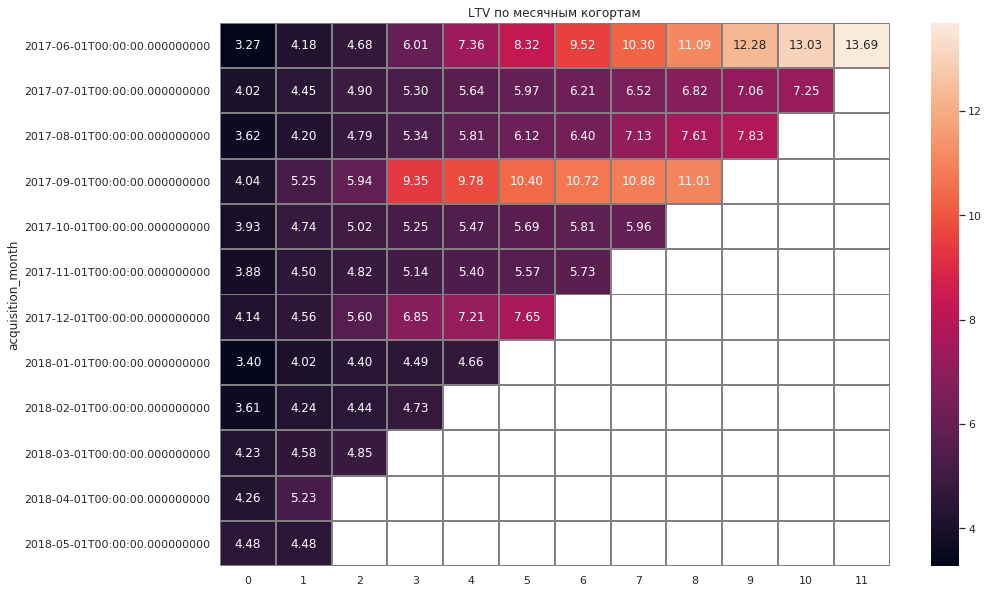

In [84]:
sns.set(style='white')
plt.figure(figsize=(15, 10))
plt.title('LTV по месячным когортам')
sns.heatmap(ltv('acquisition_month').iloc[:, 2:], fmt='.2f', annot=True, linewidths=1, linecolor='gray');

Когорты июня и сентября 2017 года покупают чаще остальных когорт. 

Клиенты когорт июня и сентября 2017 года в среднем приносят больше денег со всех своих покупок.  

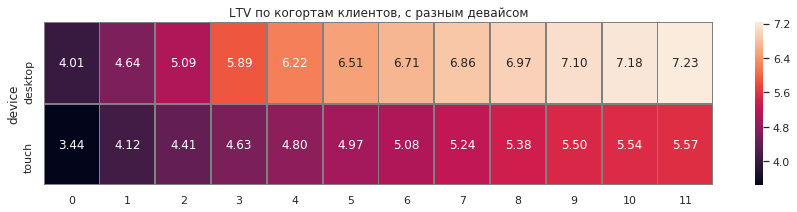

In [86]:
sns.set(style='white')
plt.figure(figsize=(15, 3))
plt.title('LTV по когортам клиентов, с разным девайсом')
sns.heatmap(ltv('device').iloc[:, 2:], fmt='.2f', annot=True, linewidths=1, linecolor='gray');

Пользователи со стационарных девайсов ценнее пользователей с мобильных устройств.

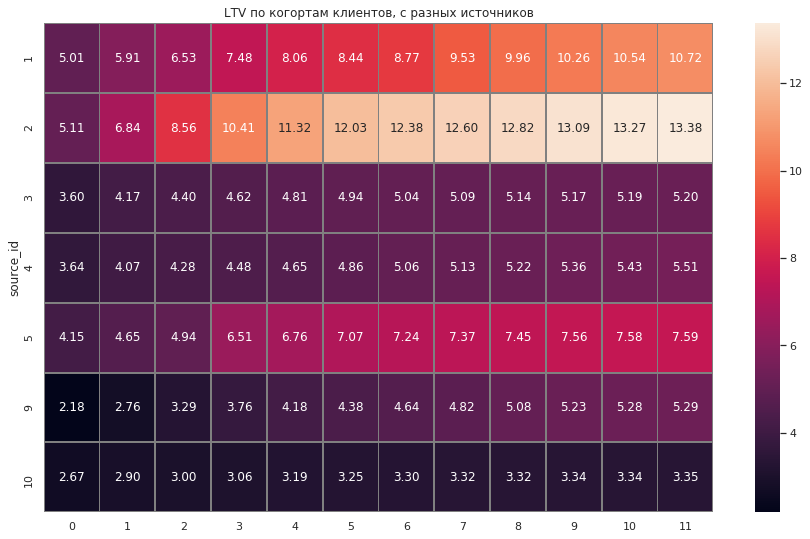

In [87]:
sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('LTV по когортам клиентов, с разных источников')
sns.heatmap(ltv('source_id').iloc[:, 2:], fmt='.2f', annot=True, linewidths=1, linecolor='gray');

С ресурсов 1 и 2 приходят более "ценные" клиенты. Также можно выделить ресур 5. 

### Маркетинг 

#### Сколько денег потратили? Всего / на каждый источник / по времени

In [88]:
def cost_sum(dimensions):
    # когорты по dimensions
    cohorts = (current_users.groupby([dimensions])
               .agg({'payer':'count', 'acquisition_cost':'sum'})
               .rename(columns={'payer':'cohort_size'}))
    cohorts['cac'] = cohorts['acquisition_cost'] / cohorts['cohort_size']
    return cohorts

In [89]:
total_sum_cost = cost_sum('acquisition_month')['acquisition_cost'].sum()
print('Всего с июня 2017 года по май 2018 года на привлечение клиентов потрачено: ', total_sum_cost.round(1))

Всего с июня 2017 года по май 2018 года на привлечение клиентов потрачено:  327215.5


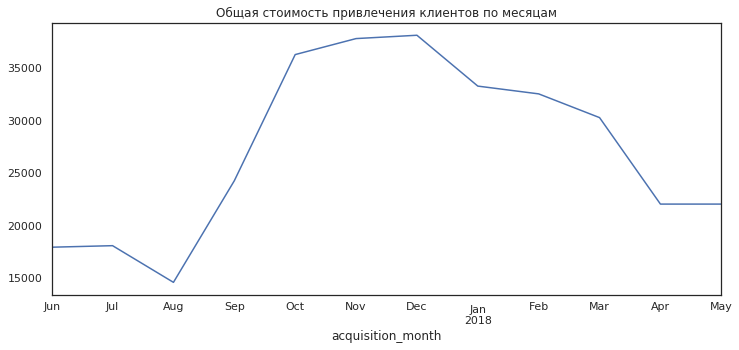

In [90]:
cost_sum('acquisition_month')['acquisition_cost'].plot(figsize=(12,5))
plt.title('Общая стоимость привлечения клиентов по месяцам');

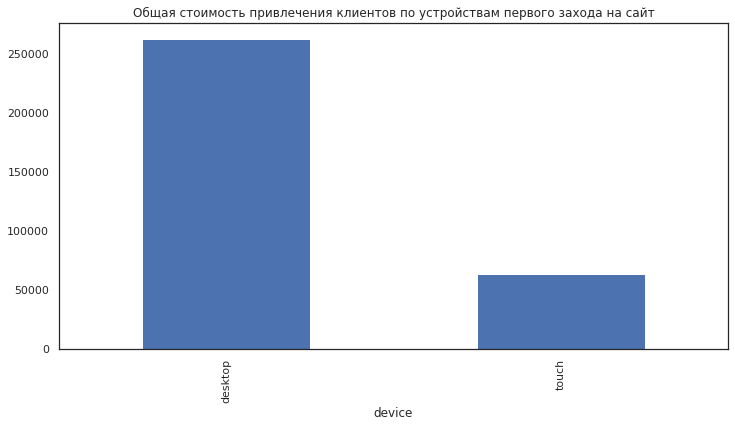

In [91]:
cost_sum('device')['acquisition_cost'].plot.bar(figsize=(12,6))
plt.title('Общая стоимость привлечения клиентов по устройствам первого захода на сайт');

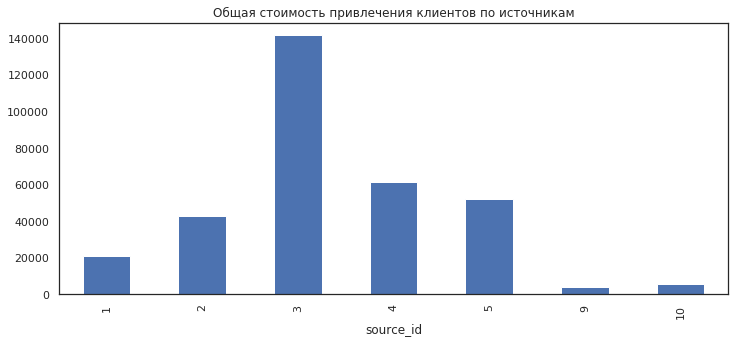

In [92]:
cost_sum('source_id')['acquisition_cost'].plot.bar(figsize=(12,5))
plt.title('Общая стоимость привлечения клиентов по источникам');

Больше на маркетинг тратят с сентября по март. Предположу, что это связано с концертными периодами, театральным сезоном, новогодними мероприятиями(если смотреть на ноябрь и декабрь).
На рекламу стационарных компьютеров и ноутбуков тратя больше. Я думаю, что пользователями лучше воспринимается реклама на больших экранах, чем на небольших экранах портативных устройств.
На маркетинг для привлечения клиентов с ресурса 3 платят больше всего (140000 единиц). Далее ресурсы 4 и 5 (60000 единиц).

#### Сколько стоило привлечение одного покупателя из каждого источника?

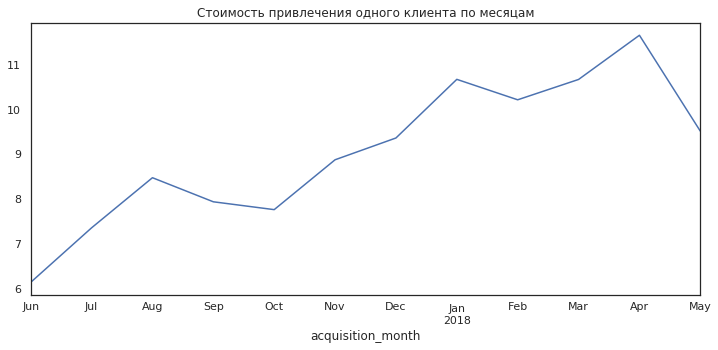

In [93]:
cost_sum('acquisition_month')['cac'].plot(figsize=(12,5))
plt.title('Стоимость привлечения одного клиента по месяцам');

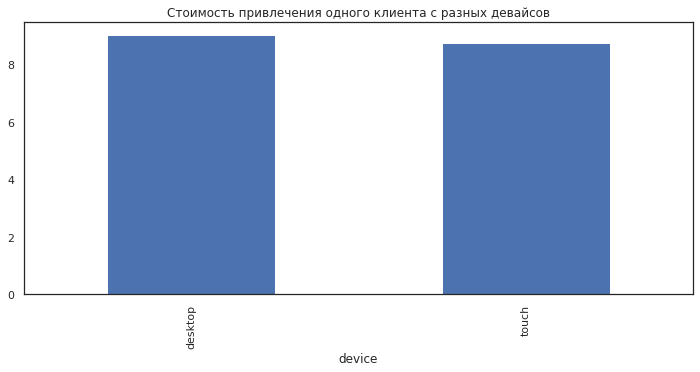

In [94]:
cost_sum('device')['cac'].plot.bar(figsize=(12,5))
plt.title('Стоимость привлечения одного клиента с разных девайсов');

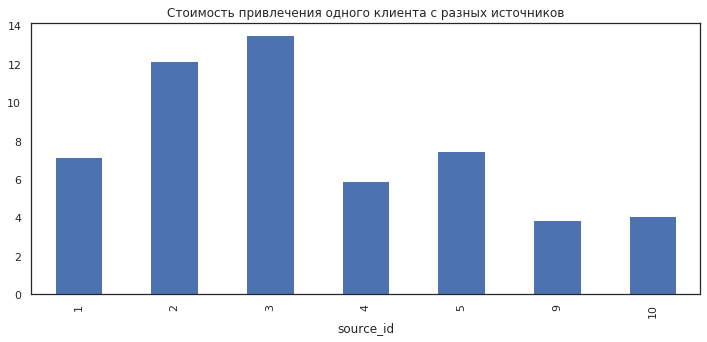

In [95]:
cost_sum('source_id')['cac'].plot.bar(figsize=(12,5))
plt.title('Стоимость привлечения одного клиента с разных источников');

* Привлечение клиентов в апреле компании обходится дороже всего. Самые низкие затраты на привлечение одного клиента в октябре.
* Привлечение клиентов обходится одинаково на разных устройствах.
* Привлечение клиентов с ресурсов 2 и 3 обходится дороже. Меньше всего затрат на одного клиента с ресурсов 9 и 10.

#### На сколько окупились расходы? (ROI)

In [96]:
for_romi = ltv('acquisition_month').drop('cohort_size', axis=1)
romi_month = for_romi.div(for_romi['cac'], axis=0).drop('cac', axis=1)

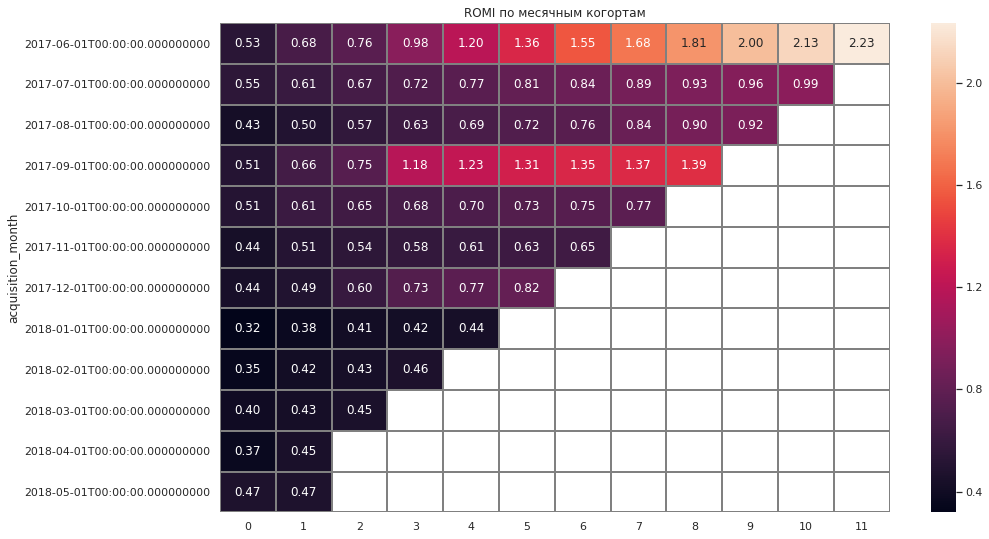

In [97]:
sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('ROMI по месячным когортам')
sns.heatmap(romi_month, fmt='.2f', annot=True, linewidths=1, linecolor='gray');

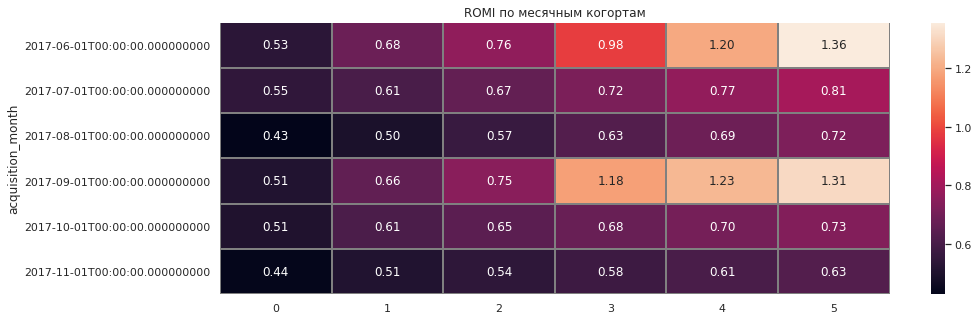

In [98]:
plt.figure(figsize=(15, 5))
plt.title('ROMI по месячным когортам')
sns.heatmap(romi_month[~romi_month[6].isna()][range(0,6)], fmt='.2f', annot=True, linewidths=1, linecolor='gray');

Июньская и сентябрская когорты 2017 года окупились за 5 и 4 месяца. Если смотреть когорты, которые уже прожили 6 месяцев и более они выделяются только две когорты, описанные ранее. Остальные когорты окупились на 60-80 %.

In [99]:
for_romi = ltv('device').drop('cohort_size', axis=1)
romi_device = for_romi.div(for_romi['cac'], axis=0).drop('cac', axis=1)

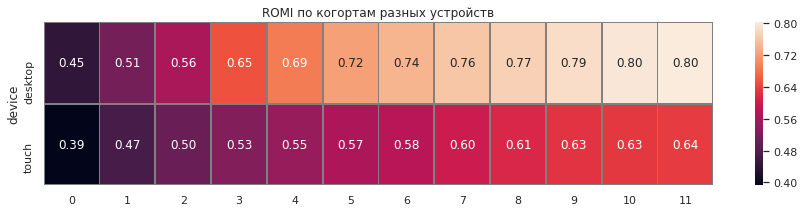

In [100]:
sns.set(style='white')
plt.figure(figsize=(15, 3))
plt.title('ROMI по когортам разных устройств')
sns.heatmap(romi_device, fmt='.2f', annot=True, linewidths=1, linecolor='gray');

In [101]:
for_romi = ltv('source_id').drop('cohort_size', axis=1)
romi_source_id = for_romi.div(for_romi['cac'], axis=0).drop('cac', axis=1)

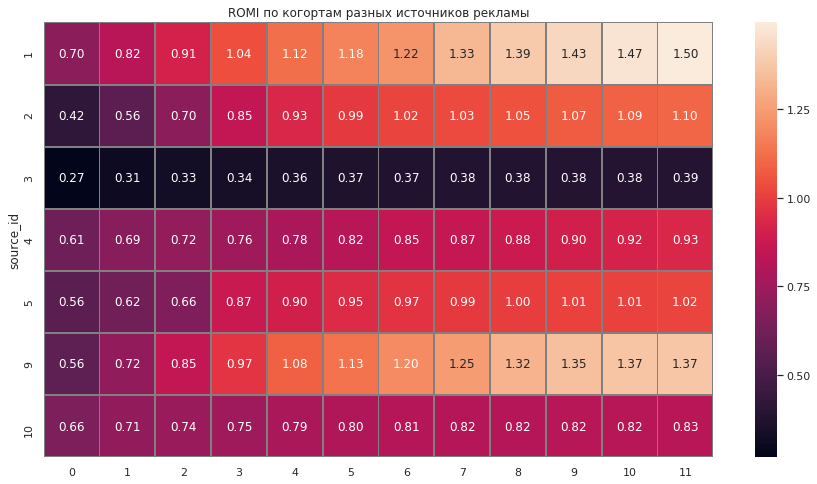

In [102]:
sns.set(style='white')
plt.figure(figsize=(15, 8))
plt.title('ROMI по когортам разных источников рекламы')
sns.heatmap(romi_source_id, fmt='.2f', annot=True, linewidths=1, linecolor='gray');

* Десктопные пользователи окупились на 80 %, мобильные - на 64 %.
* За 4 месяца окупились клиенты с источника 1, за 5 месяцев - с источника 9, за 6 месяцев - с источника 2 и за 9 месяцев - с источника 5. Остальные источники не окупились за 12 месяцев. Окупаемость источника 3 увеличилась на 12% за 12 месяцев.

### Шаг 3. Напишите вывод: порекомендуйте маркетологам, куда и сколько им стоит вкладывать денег?

#### Какие источники/платформы вы бы порекомендовали? Объясните свой выбор: на какие метрики вы ориентируетесь? Почему? Какие выводы вы сделали, узнав значение метрик?

По моему мнению источники 1, 2, 5, 9 наиболее интересны для маркетологов. 
Для анализа в основном опирался на такие метрики как ROMI, CAC и LTV.

Клиенты с источника 1 окупаются за 4 месяца, стоимость привлечения около 7 единиц, клиентов с этого источника можно считать ценными, так как продолжают делать покупки и приносят среднюю сумму со всех покупок за 12 месяцев около 10.7 единиц.

Клиенты с источника 2 окупаются за 6-7 месяцев, стоимость привлечения около 12 единиц, клиенты с этого ресурса самые ценные,  средняя сумма со всех покупок за 12 месяцев около 13.4 единиц.

Клиенты с источника 5 окупаются за 8-9 месяцев, стоимость привлечения около 8 единиц, клиенты с этого ресурса считаю ценными, так как они продолжают делать покупки и приносят среднюю сумму со всех покупок за 12 месяцев около 7.6 единиц.

Ресурс 9 быстро окупается (5 месяцев), так как ценность клиентов (LTV) средняя по всем источникам 5.3 единицы, но стоимость привлечения одного клиента минимальная и находится в районе 4 единицы.

С ресурсов 3 и 4 приходят больше всего покупателей, но клиенты с этих ресурсов не так быстро окупаются. 
Затраты одного клиента источника 3 составляют 13 единиц, и за весь период было потрачено почти 140 тыс.единиц из 327 тыс. на все маркетинг для всех площадок. Окупаемость за 12 месяцев составила только 40 % от вложений. 

Источник 4 приводит клиентов, у которых средняя сумма покупок (LTV) меньше, чем из источника 5, хотя общие затраты на период и стоимость привлечения одного клинта примерно одинаковы. Поэтому источник 5 окупается быстрее.

Источник 10 имеет чуть больше вложений в маркетинг, чем в источник 9. Стоимость привлечения одного клиента сравнимую с 9 источником, но ценность покупателей их 10 источника ниже. Окупаемость этого источника может затянуться на несколько лет. Когда окупаемость 9 источника наступила через 4 месяца.

Мое мнение, что с источника 3 стоить перераспределить вложения на источники 1,2 и 5. Потому что клиенты из этих источников более ценнные, и в перспективе сделают прибыль больше.

* Самые ценные клиенты приходят в июне и сентября, и когорты этих месяцев быстрее окупили вложения на рекламу. В июне стоимость привлечения клиентов минимальная за 12 месяцев, в сентябре находится на небольших стоимостях. 
* С десктопных устройств пользователей больше, чем с мобильных. Стоимости привлечения клиентов с разных устройств не отличается. На десктопные устройства затраты на рекламу больше, но ккупаемость лучше. 
* Стоит обратить внимание на источники 1, 2, 5 и 9. Они более интересные по ценности клиентов, по стоимость привлечения одного клиента и по окупаемости привлечения клиентов.  